#Library & Data Imports


In [ ]:
#setting up libraries and mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Date manipulation
from datetime import datetime as dt

import warnings

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score


from sklearn.model_selection import train_test_split



In [ ]:
data = pd.read_csv("Concussion Injuries 2012-2014.csv")

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
sns.set(rc={'figure.figsize': (16, 8)})
plt.style.use('fivethirtyeight')

# Introduction

### Exploratory Data Analysis
These are data science methods we use to gain insights about our data, get it ready for processing and make decisions about models to use, and actions to take.

In [ ]:
data = pd.read_csv("/content/sample_data/Concussion Injuries 2012-2014.csv")

In [ ]:
data.head(2)

,ID,Player,Team,Game,Date,Opposing Team,Position,Pre-Season Injury?,Winning Team?,Week of Injury,Season,Weeks Injured,Games Missed,Unknown Injury?,Reported Injury Type,Total Snaps,Play Time After Injury,Average Playtime Before Injury
0,Aldrick Robinson - Washington Redskins vs. Tam...,Aldrick Robinson,Washington Redskins,Washington Redskins vs. Tampa Bay Buccaneers (...,30/09/2012,Tampa Bay Buccaneers,Wide Receiver,No,Yes,4,2012/2013,1,1.0,No,Head,0,14 downs,37.00 downs
1,D.J. Fluker - Tennessee Titans vs. San Diego C...,D.J. Fluker,San Diego Chargers,Tennessee Titans vs. San Diego Chargers (22/9/...,22/09/2013,Tennessee Titans,Offensive Tackle,No,No,3,2013/2014,1,1.0,No,Concussion,0,78 downs,73.50 downs


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              392 non-null    object 
 1   Player                          392 non-null    object 
 2   Team                            392 non-null    object 
 3   Game                            392 non-null    object 
 4   Date                            392 non-null    object 
 5   Opposing Team                   392 non-null    object 
 6   Position                        392 non-null    object 
 7   Pre-Season Injury?              392 non-null    object 
 8   Winning Team?                   392 non-null    object 
 9   Week of Injury                  392 non-null    int64  
 10  Season                          392 non-null    object 
 11  Weeks Injured                   392 non-null    int64  
 12  Games Missed                    361 

We cleaned the dataset first, and changed the data type of the date column.

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])

The Play Time After Injury and Average Playtime Before Injury columns are also encoded from objects to numbers so we can check later for distribution.

In [ ]:
data["Play Time After Injury"] = data["Play Time After Injury"].replace("Did not return from injury", 0)
data["Play Time After Injury"].fillna(0, inplace=True)
data['Play Time After Injury'] = data['Play Time After Injury'].str.replace(r'\D+', '', regex=True).fillna(0)
data['Play Time After Injury'] = data['Play Time After Injury'].astype(int)

In [ ]:
data["Average Playtime Before Injury"].fillna(0, inplace=True)
data['Average Playtime Before Injury'] = data['Average Playtime Before Injury'].str.replace(r'\D+', '', regex=True).fillna(0)
data['Average Playtime Before Injury'] = data['Average Playtime Before Injury'].astype(int)

In [ ]:
data.describe()

,Week of Injury,Weeks Injured,Games Missed,Total Snaps,Play Time After Injury,Average Playtime Before Injury
count,392.000000,392.000000,361.000000,392.000000,392.000000,392.000000
mean,8.548469,0.920918,0.925208,32.038265,38.505102,4125.609694
std,5.004111,0.270211,1.742429,22.228552,28.853630,2431.476362
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,14.000000,12.000000,2250.000000
50%,9.000000,1.000000,0.000000,29.000000,38.000000,4331.500000
75%,13.000000,1.000000,1.000000,48.000000,64.000000,6218.500000
max,19.000000,1.000000,14.000000,93.000000,99.000000,8467.000000


38 downs, is the median number of downs players play after getting injured.

### Reported Injury Type

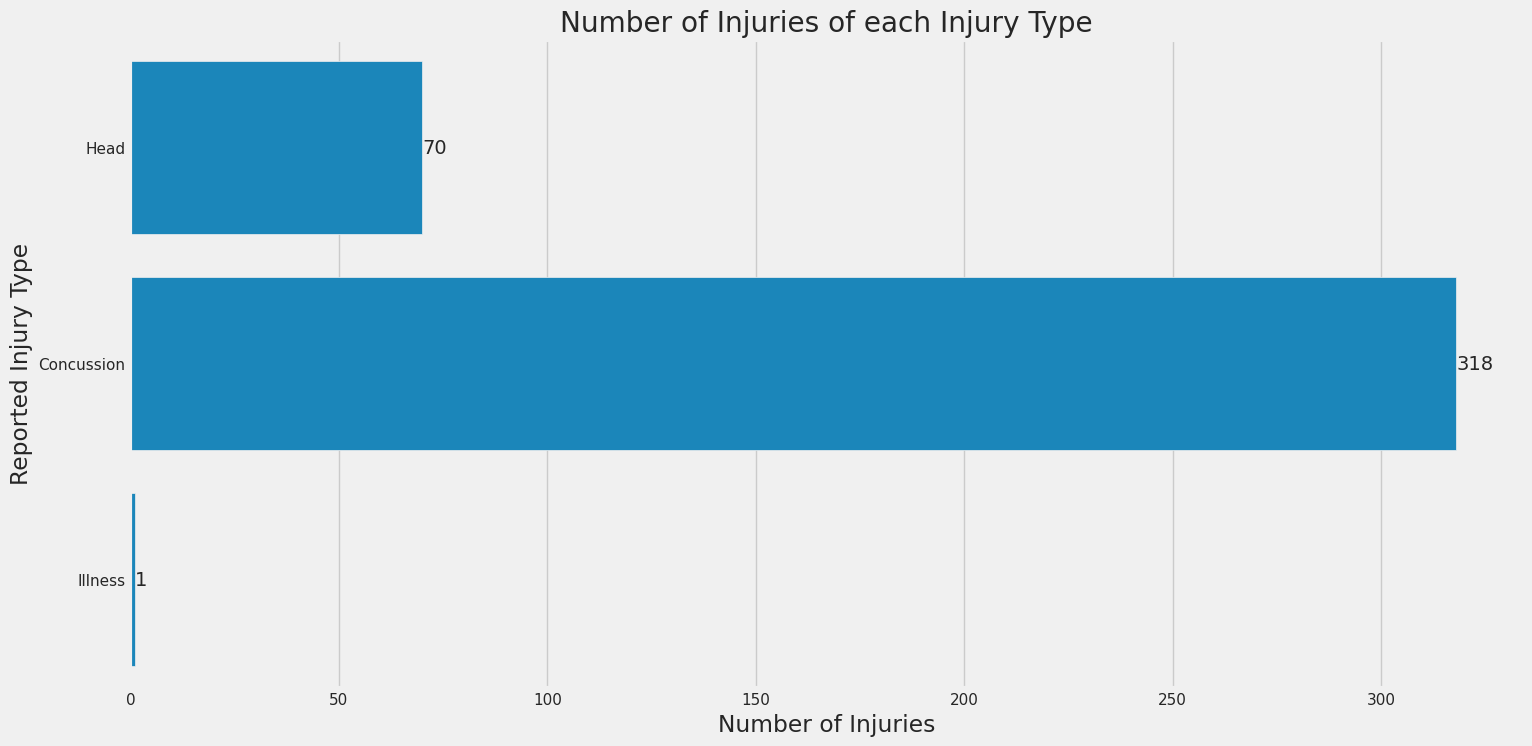

In [ ]:
plot = sns.countplot(y="Reported Injury Type", data=data)
plt.bar_label(plot.containers[0])

plt.xlabel("Number of Injuries")
plt.title("Number of Injuries of each Injury Type")
plt.show()

Most of reported injuries in the dataset are Concussions.

### Injuries Distribution by Date

In [ ]:
by_date = data.groupby(["Date"], sort=True)["ID"].count()

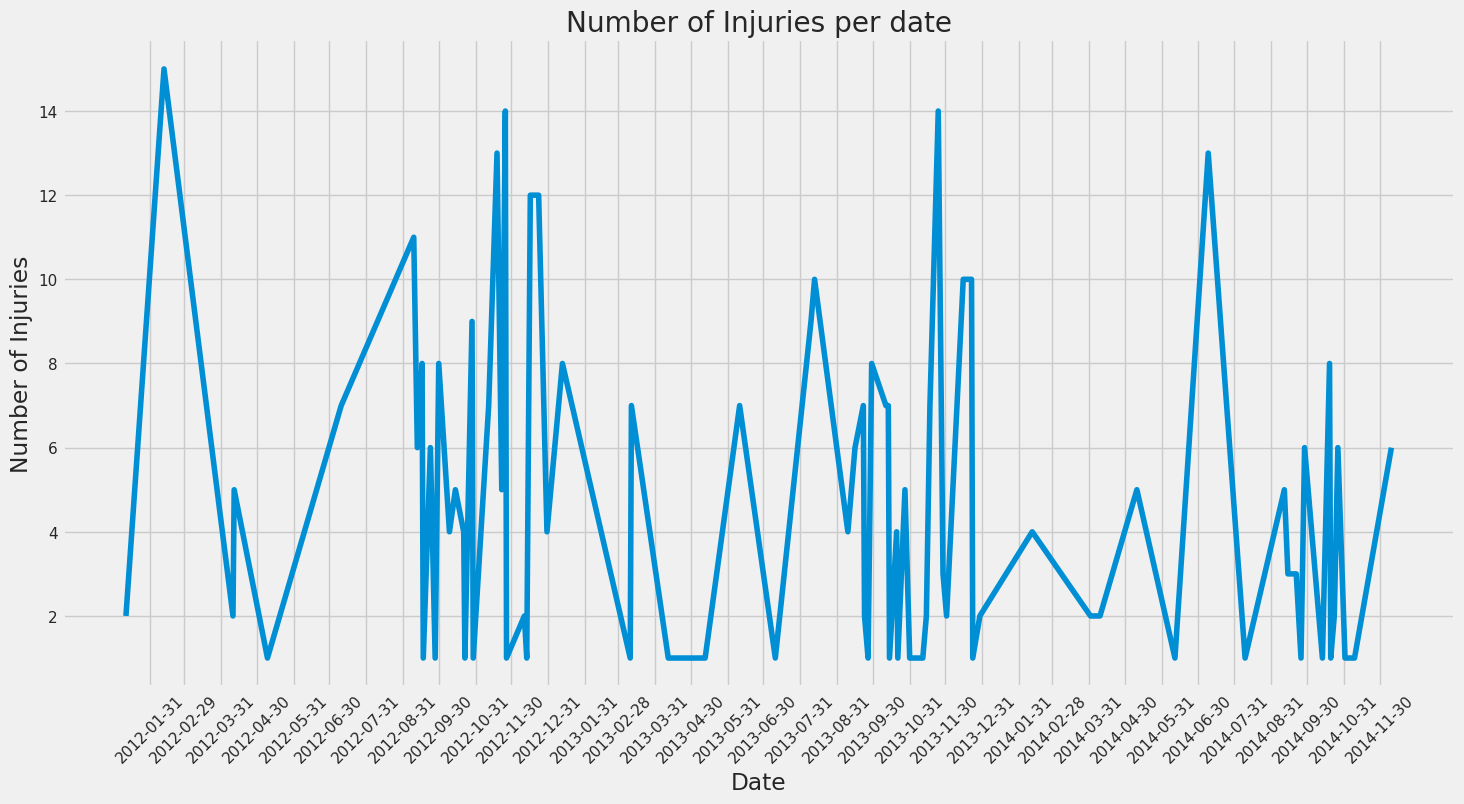

In [ ]:
sns.lineplot(x=by_date.index, y=by_date.values)

plt.xticks(pd.date_range(by_date.index[0], by_date.index[-1], freq="M"), rotation=45)

plt.xlabel("Date")
plt.ylabel("Number of Injuries")
plt.title("Number of Injuries per date")

plt.show()

From the first glimpse, we cannot see any pattern or trend in the data, we will use statsmodels package that will detect if there is an increasing or decreasing trend of number of injuries. <br>
<b>Trend:</b> We want to conclude if the data follow a consistent upwards or downward slope?

In [ ]:
by_date.sort_index(inplace=True)
by_date = by_date.to_frame()

In [ ]:
import statsmodels.api as sm
decomp = sm.tsa.seasonal_decompose(by_date, period=int(len(by_date)/2))

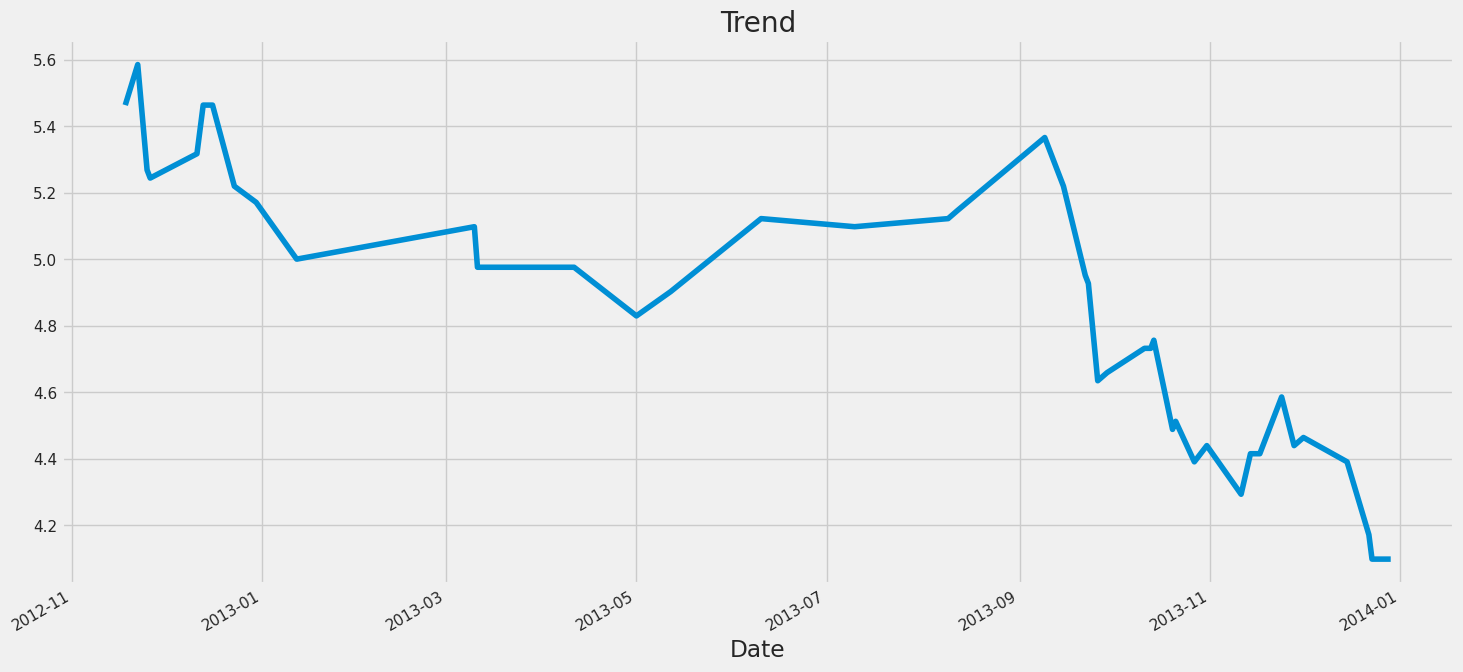

In [ ]:
ax = decomp.trend.plot()

ax.set_xlabel('Date')
ax.set_title('Trend')

plt.show()

After decomposing data, we can clearly see that number of head injuries slightly decreased in NFL over time.

### Team

What team has the highest number of head injuries?

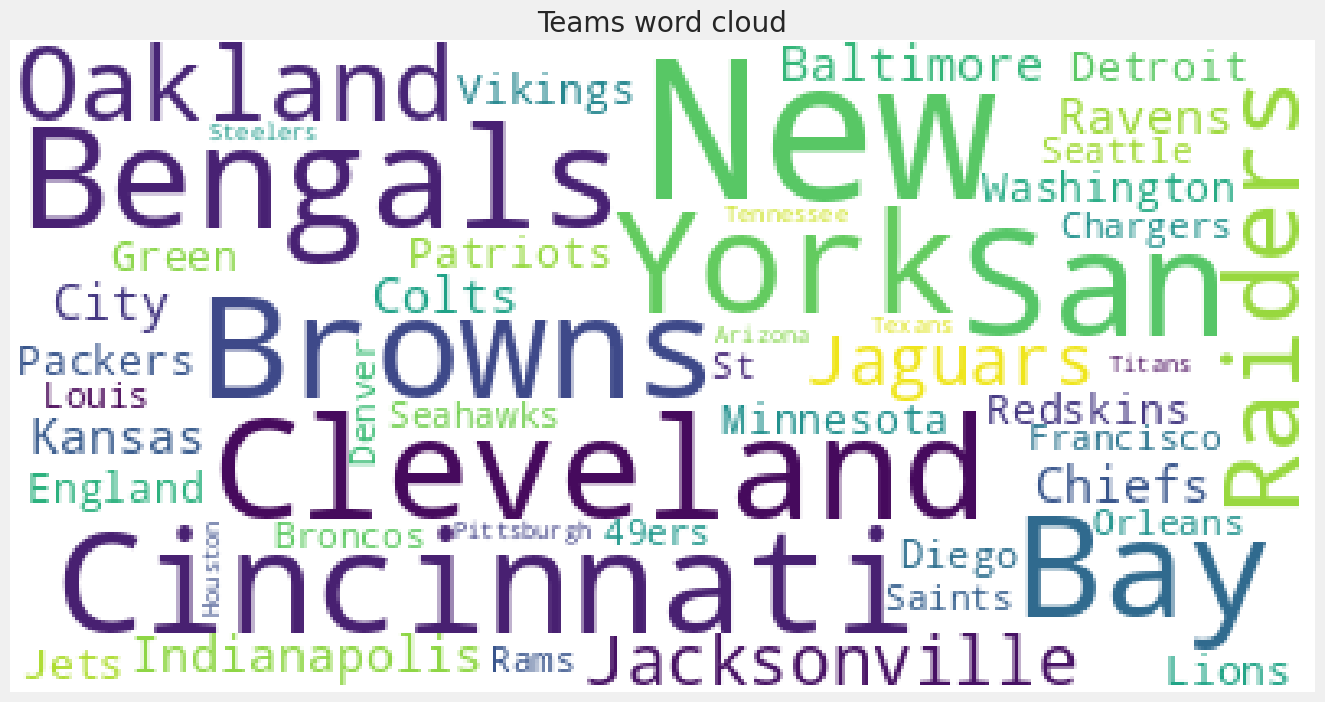

In [ ]:
wordcloud = WordCloud(
                          background_color='white',
                          collocations=False,
                          stopwords=STOPWORDS,
                          max_words=50,
                          max_font_size=60,
                          random_state=42,
                         ).generate(str(data['Team']))

plt.figure(figsize = (15,15))
plt.imshow(wordcloud)
plt.title("Teams word cloud")
plt.axis('off')
plt.show()

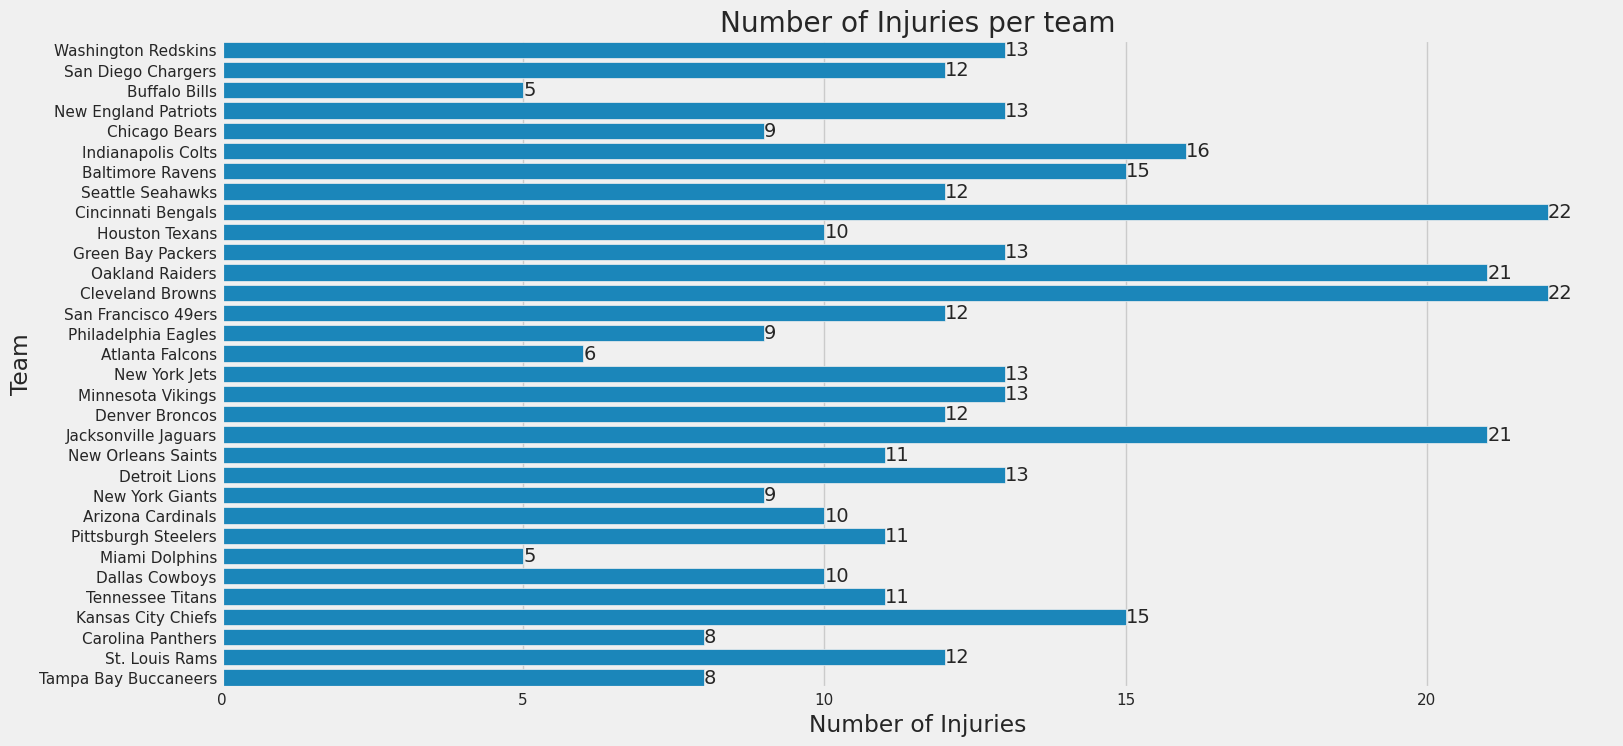

In [ ]:
plot = sns.countplot(y="Team", data=data)

plt.bar_label(plot.containers[0])
plt.xlabel("Number of Injuries")
plt.ylabel("Team")
plt.title("Number of Injuries per team")

plt.show()

Cincinnati Bengals, Oakland Raiders, Cleveland Browns and Jacksonville Jaguars, are the teams with the highest number of head injuries.

In [ ]:
pd.pivot_table(data, index=["Team"], columns="Reported Injury Type", aggfunc="count")["Game"].sort_values("Concussion", ascending=False).fillna(0)

Reported Injury Type,Concussion,Head,Illness
Team,,,
Oakland Raiders,21.0,0.0,0.0
Jacksonville Jaguars,20.0,1.0,0.0
Cincinnati Bengals,17.0,4.0,0.0
Minnesota Vikings,13.0,0.0,0.0
New York Jets,13.0,0.0,0.0
Green Bay Packers,13.0,0.0,0.0
San Diego Chargers,12.0,0.0,0.0
San Francisco 49ers,12.0,0.0,0.0
Cleveland Browns,12.0,10.0,0.0


Oakland Raiders had 21 head injury among their players in only 3 seasons! Which is terrible. This can be due to weak equipment, bad medical staff, or just luck.

### Opposing Team

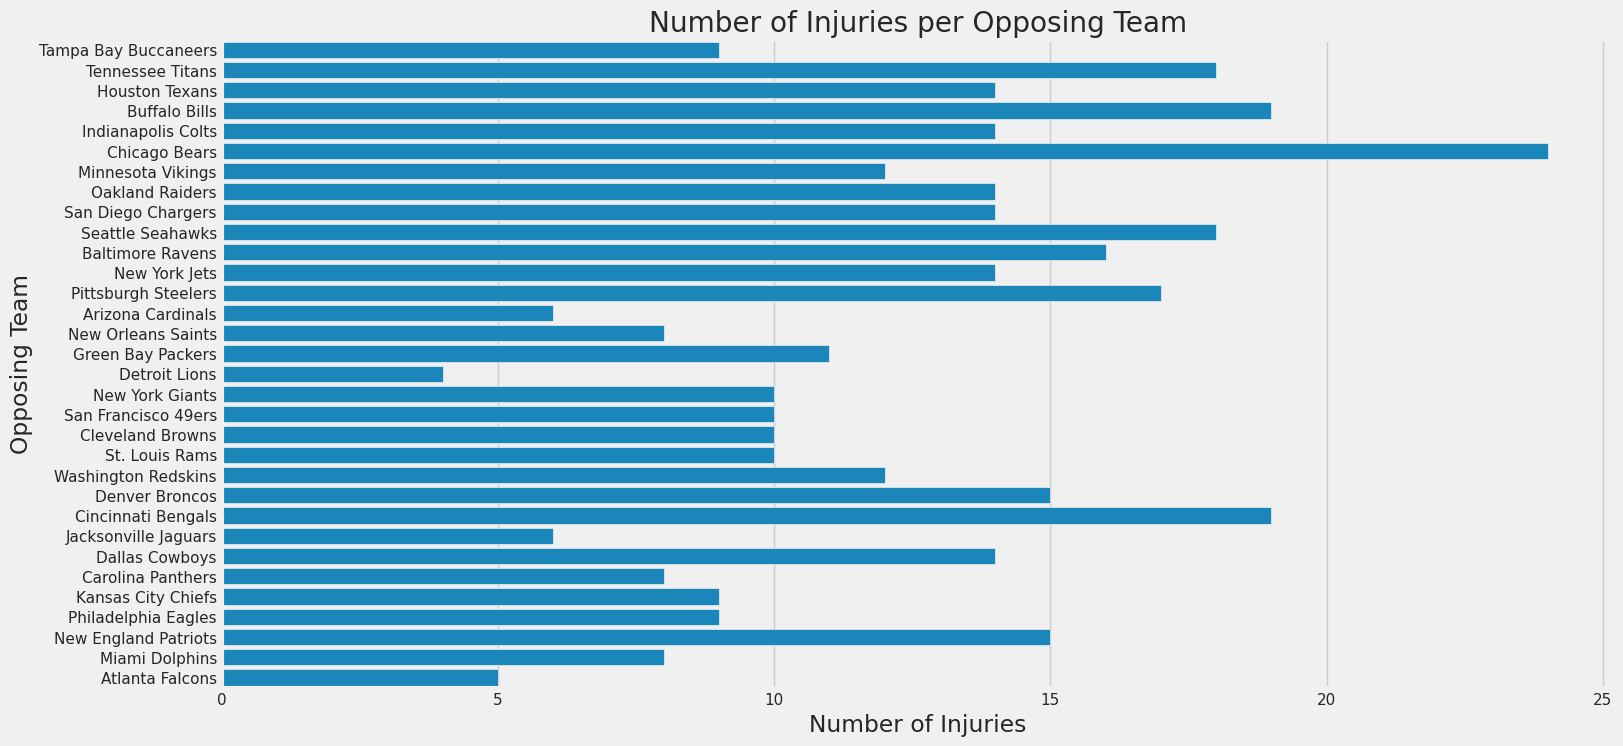

In [ ]:
sns.countplot(y="Opposing Team", data=data)

plt.xlabel("Number of Injuries")
plt.ylabel("Opposing Team")
plt.title("Number of Injuries per Opposing Team")


plt.show()

Chicago Bears are the opposing team with the highest number of head injuries, they are maybe playing more aggressively.

In [ ]:
pd.pivot_table(data, index=["Opposing Team"], columns="Reported Injury Type", aggfunc="count")["Game"].sort_values("Concussion", ascending=False).fillna(0)

Reported Injury Type,Concussion,Head,Illness
Opposing Team,,,
Chicago Bears,19.0,5.0,0.0
Tennessee Titans,17.0,0.0,0.0
Seattle Seahawks,15.0,2.0,0.0
Baltimore Ravens,14.0,2.0,0.0
Buffalo Bills,14.0,5.0,0.0
Cincinnati Bengals,14.0,5.0,0.0
New York Jets,14.0,0.0,0.0
Indianapolis Colts,13.0,1.0,0.0
Houston Texans,13.0,1.0,0.0


### Number of Games Missed

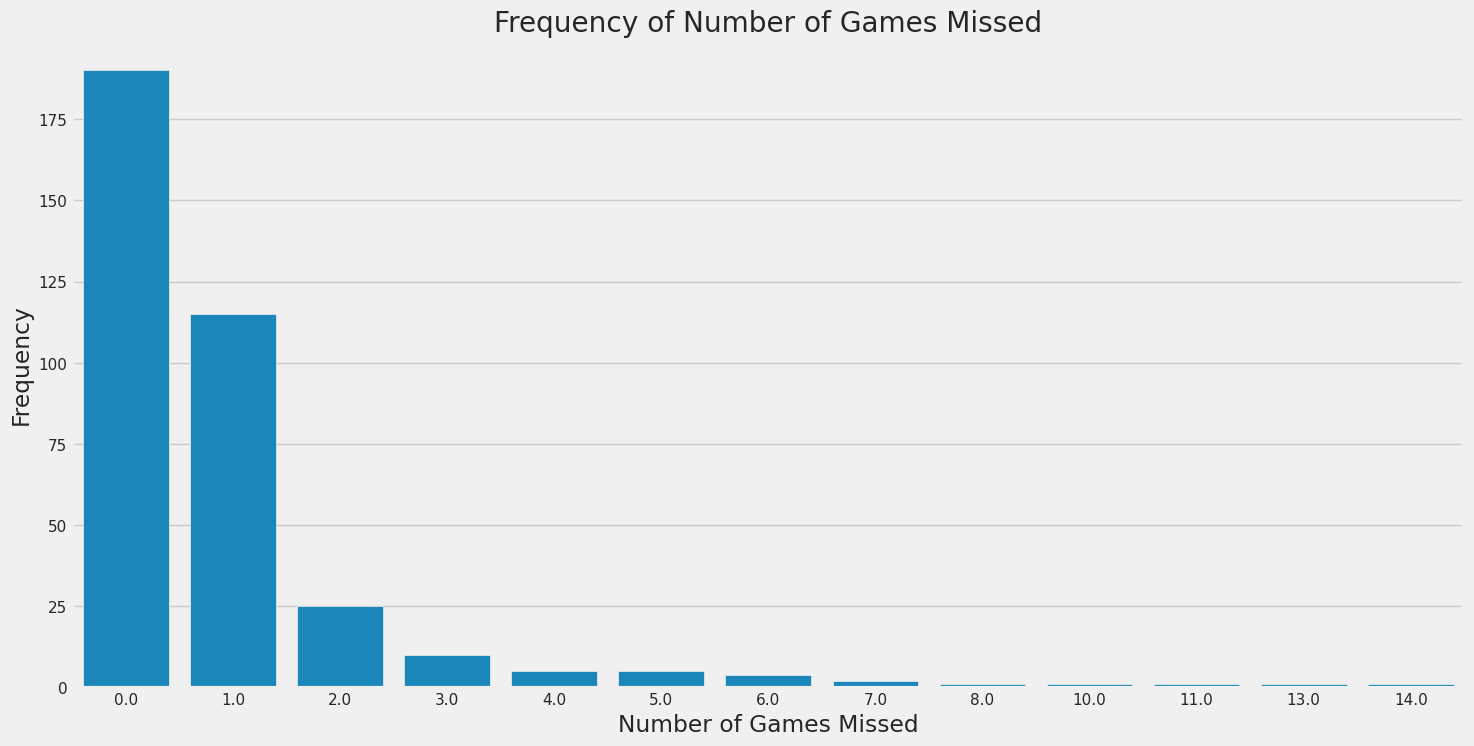

In [ ]:
sns.countplot(x="Games Missed", data=data)

plt.xlabel("Number of Games Missed")
plt.ylabel("Frequency")
plt.title("Frequency of Number of Games Missed")


plt.show()

More than 175 players that suffered from head injuries, did not miss any game!

### Number of Injuries per Position

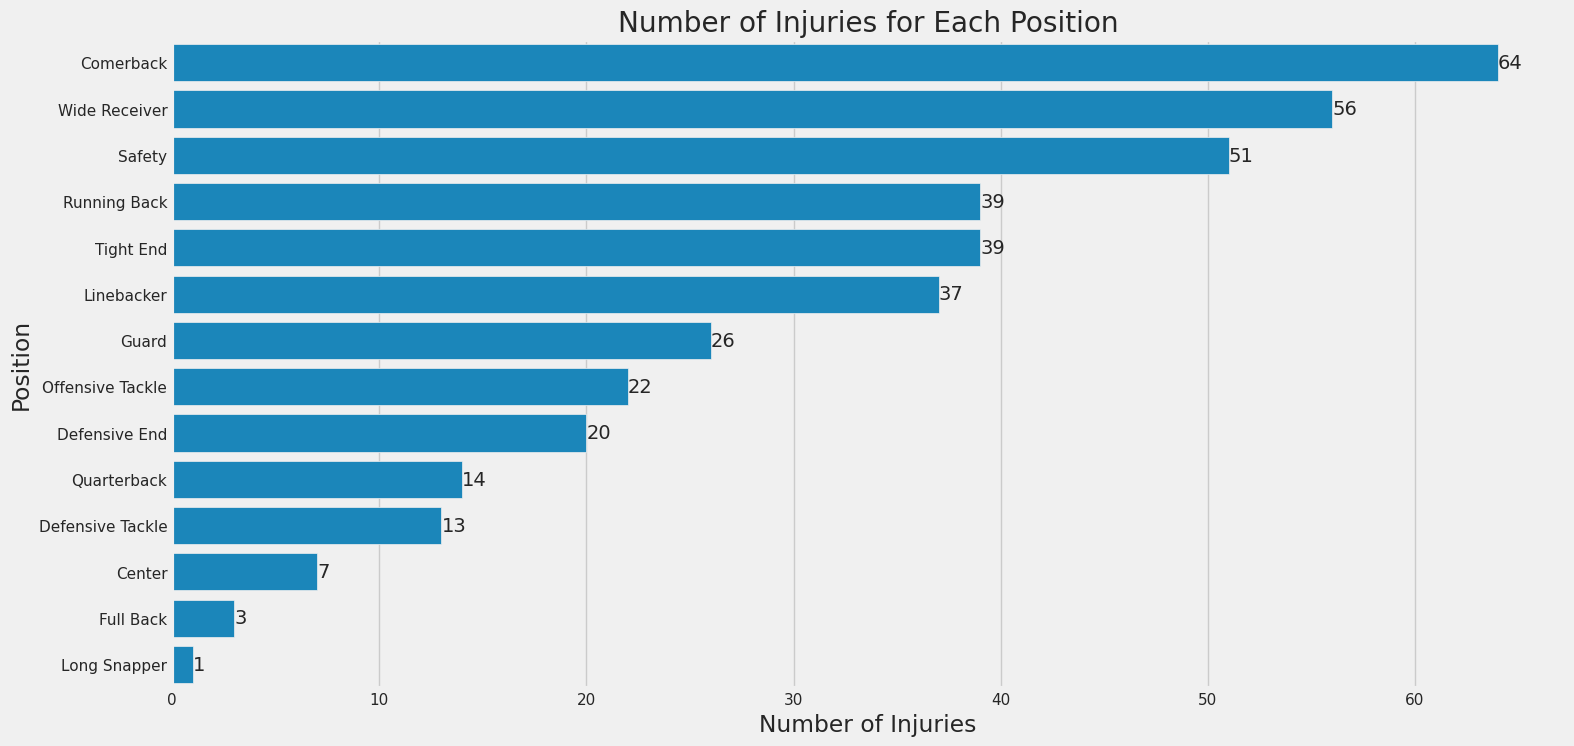

In [ ]:
by_pos = data["Position"].value_counts()
plot = sns.barplot(y=by_pos.index, x=by_pos.values)
plt.bar_label(plot.containers[0])

plt.xlabel("Number of Injuries")
plt.ylabel("Position")
plt.title("Number of Injuries for Each Position")

plt.show()

When playing defensive, players are more at risk of head injuries.

### Were they winning?

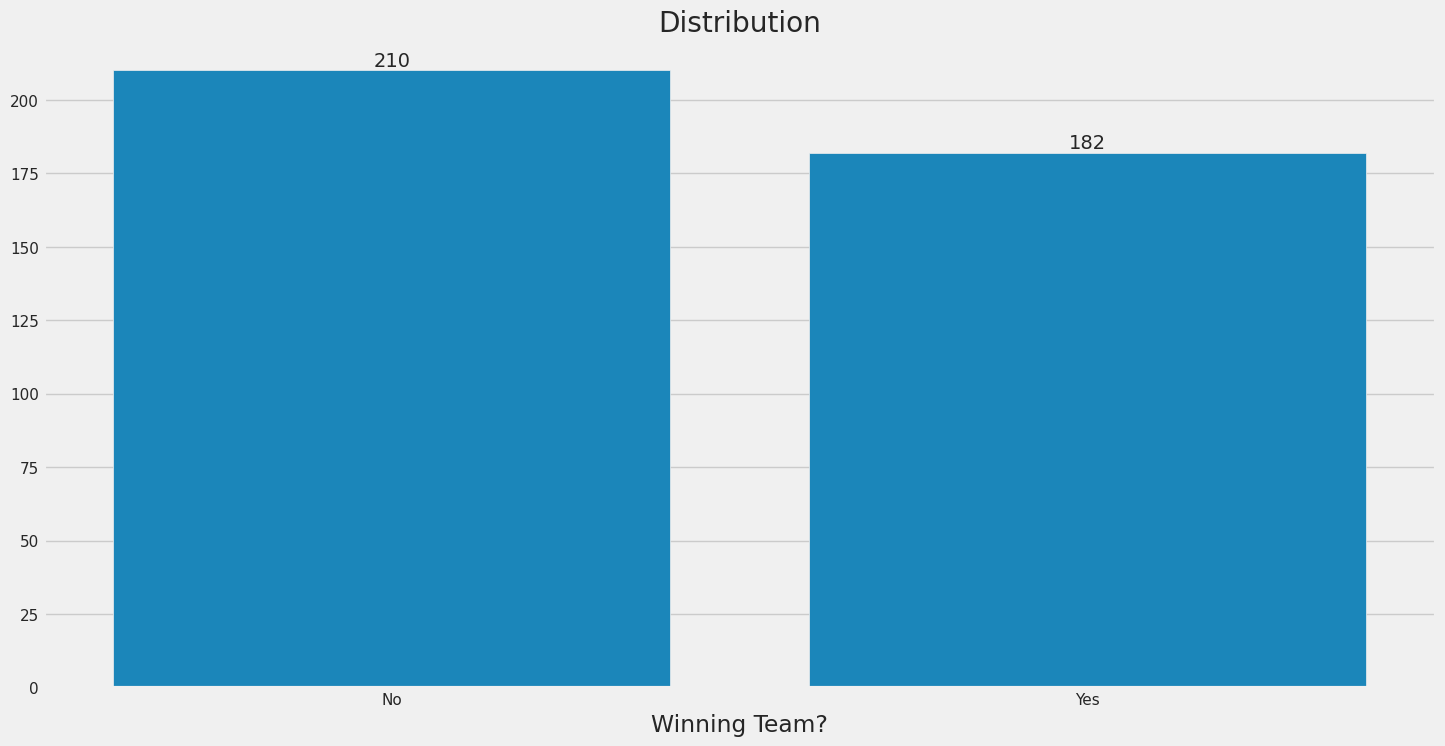

In [ ]:
by_win = data["Winning Team?"].value_counts()
plot = sns.barplot(x=by_win.index, y=by_win.values)
plt.bar_label(plot.containers[0])

plt.xlabel("Winning Team?")
plt.title("Distribution")


plt.show()

210 Players that suffered from head injuries were losing, 182 players were winning, we cannot see a clear pattern here since the two numbers are too close.

### Number of Injuries per Season

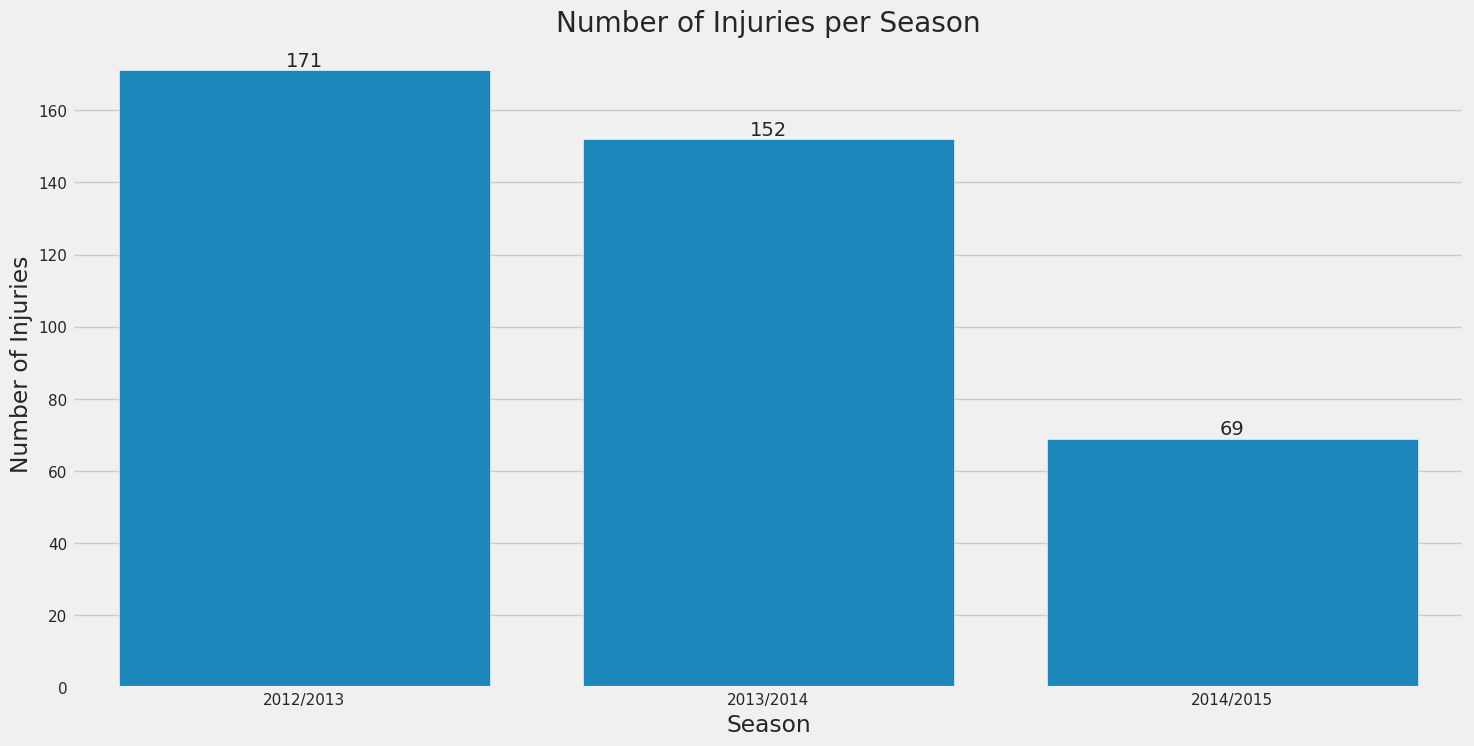

In [ ]:
by_sea = data["Season"].value_counts()
plot = sns.barplot(x=by_sea.index, y=by_sea.values)
plt.bar_label(plot.containers[0])

plt.xlabel("Season")
plt.ylabel("Number of Injuries")
plt.title("Number of Injuries per Season")


plt.show()

As we discussed earlier in the decomposition, number of injuries is decreasing over time.

### Was the player injured pre-season?

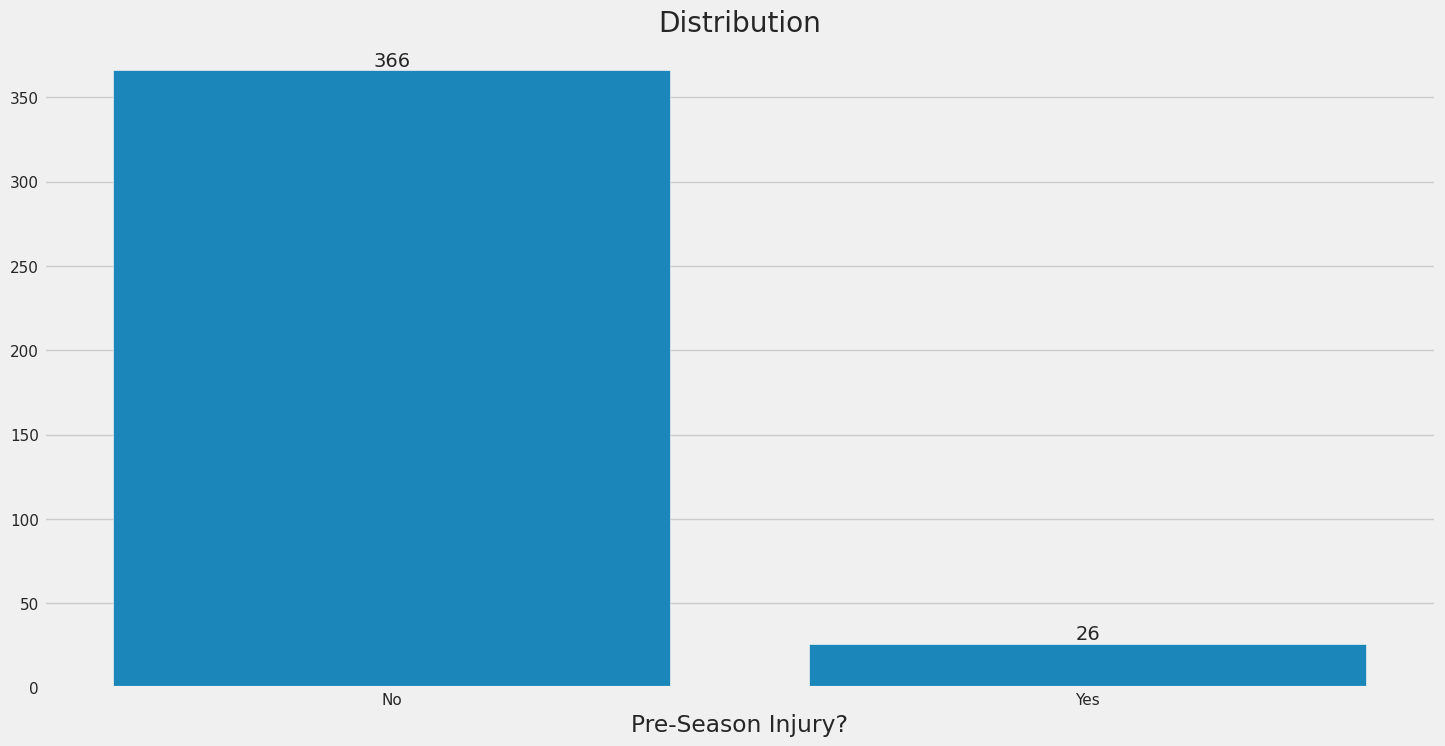

In [ ]:
pre_sea = data["Pre-Season Injury?"].value_counts()
plot = sns.barplot(x=pre_sea.index, y=pre_sea.values)
plt.bar_label(plot.containers[0])

plt.xlabel("Pre-Season Injury?")
plt.title("Distribution")


plt.show()

Most players that got head injuries were not injured in the pre-season, so there is no relationship between these two factors.

### Total Snaps per Date

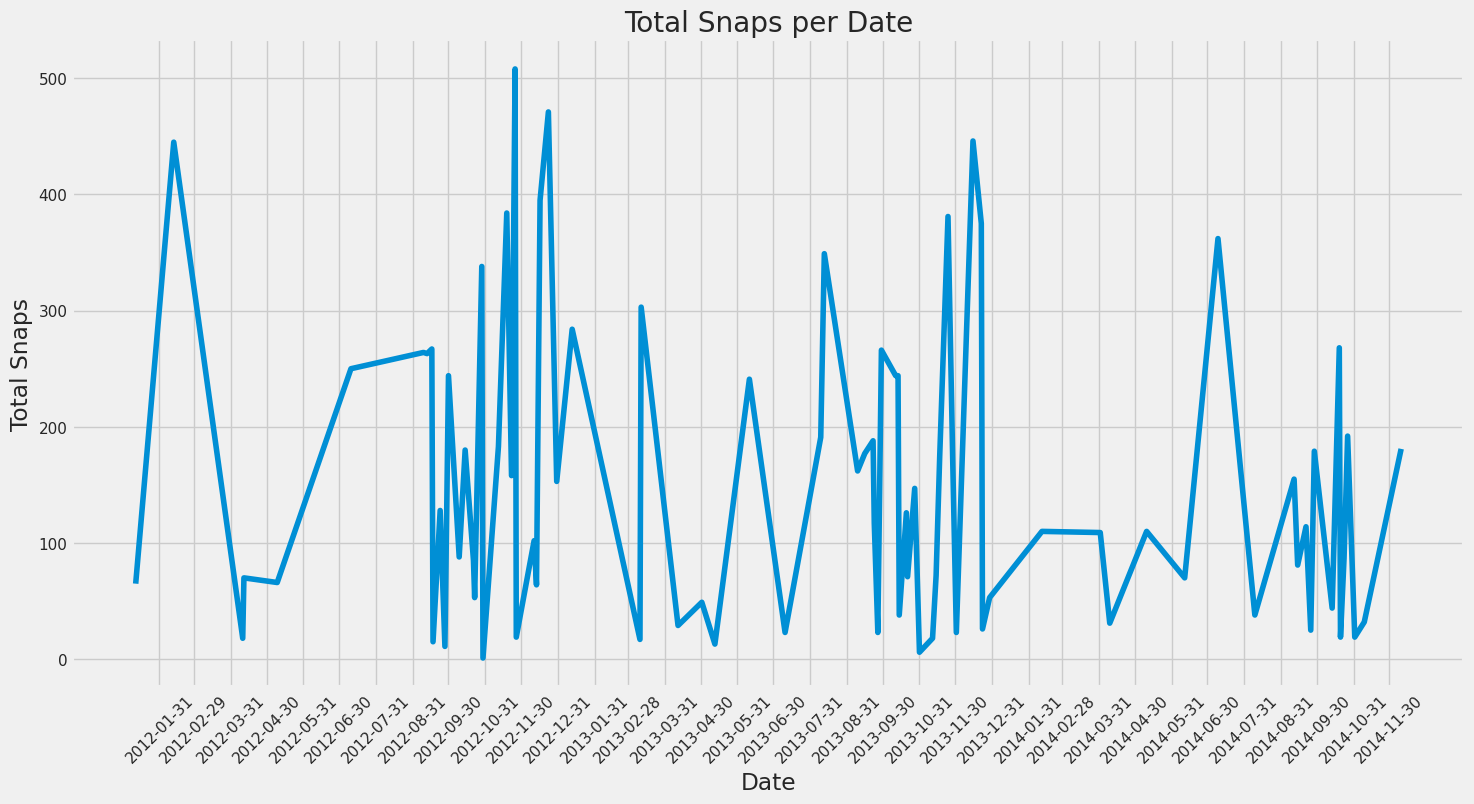

In [ ]:
snaps = data.groupby("Date")["Total Snaps"].sum()
sns.lineplot(x=snaps.index, y=snaps.values)
plt.xticks(pd.date_range(snaps.index[0], snaps.index[-1], freq="M"), rotation=45)

plt.xlabel("Date")
plt.ylabel("Total Snaps")
plt.title("Total Snaps per Date")


plt.show()

Again, we cannot see any pattern, instead, lets visualize total snaps per season.

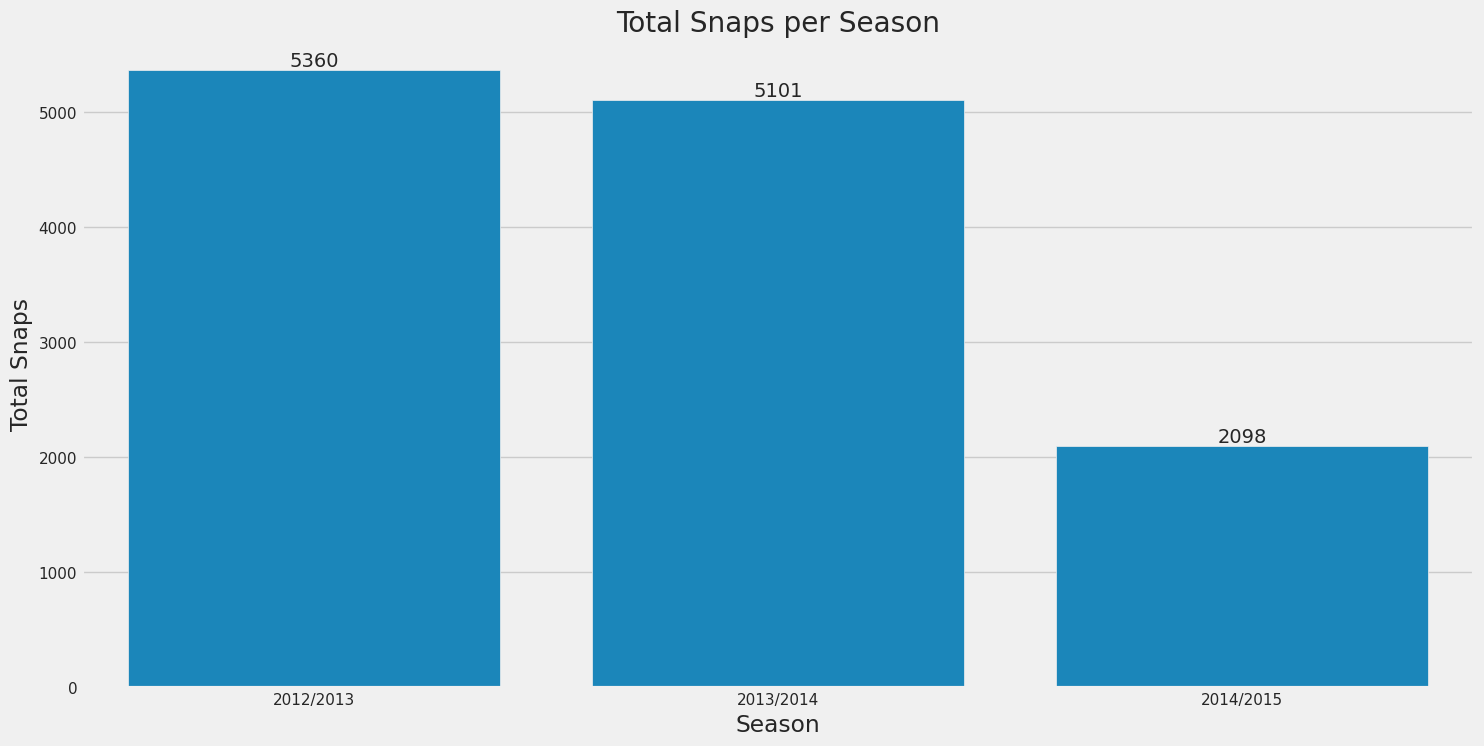

In [ ]:
by_sea_snaps = data.groupby("Season")["Total Snaps"].sum()
plot = sns.barplot(x=by_sea_snaps.index, y=by_sea_snaps.values)
plt.bar_label(plot.containers[0])

plt.xlabel("Season")
plt.ylabel("Total Snaps")
plt.title("Total Snaps per Season")


plt.show()

Total snaps has decreased over time.

### Total Snaps per Team

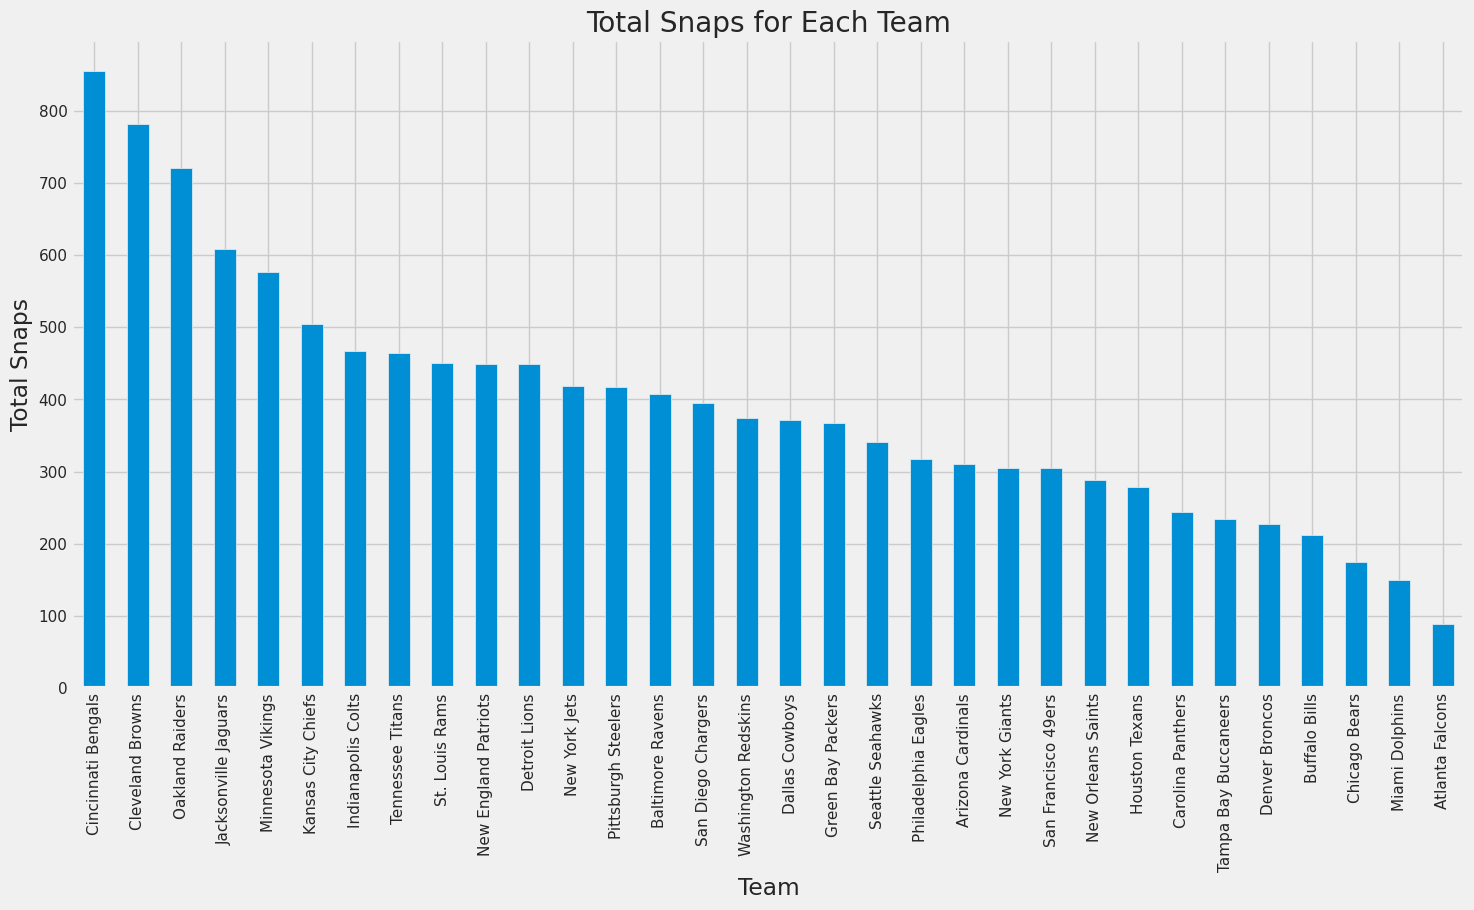

In [ ]:
data.groupby(["Team"])["Total Snaps"].sum().sort_values(ascending=False).plot(kind="bar")

plt.xlabel("Team")
plt.ylabel("Total Snaps")
plt.title("Total Snaps for Each Team")


plt.show()

Cincinnati Bengals had the highest number of total snaps.

### Play Time After Injury Distribution

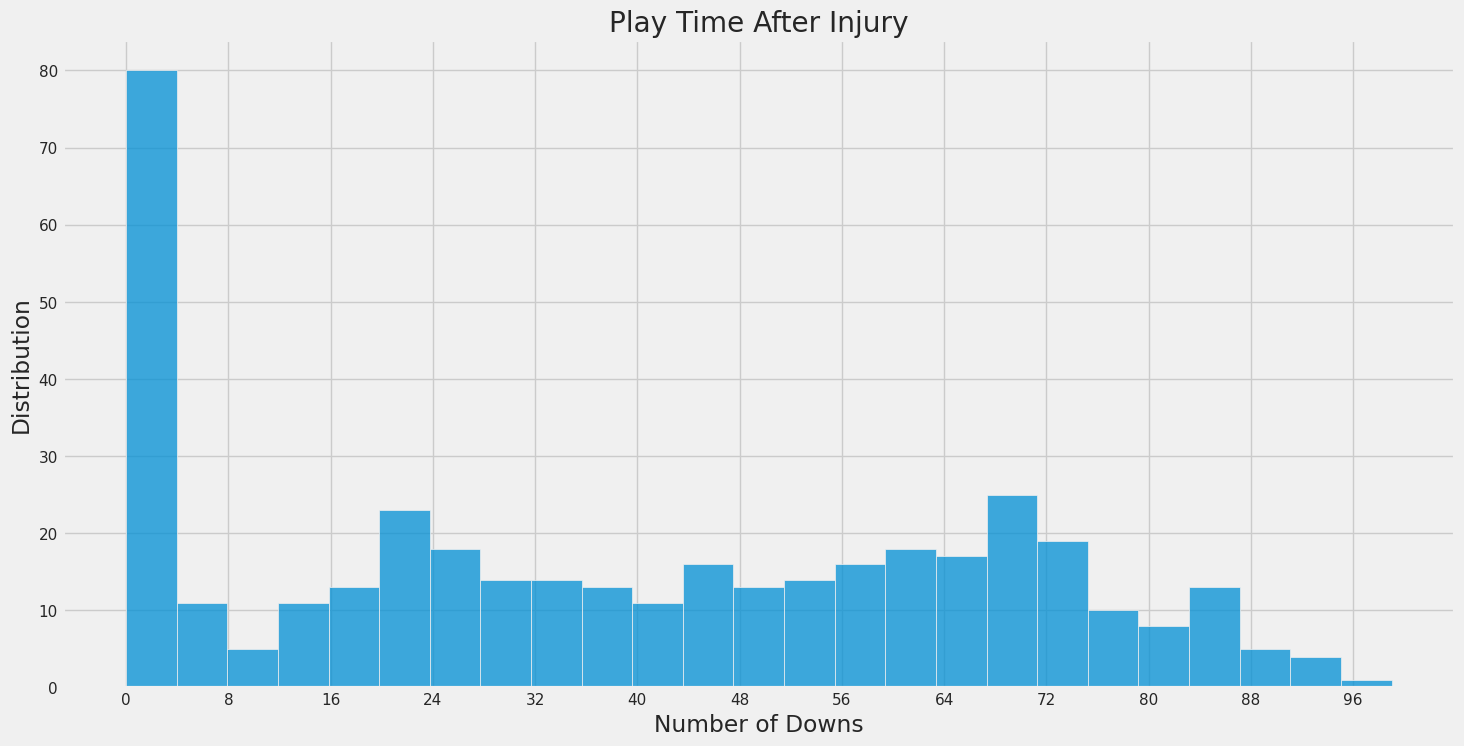

In [ ]:
sns.histplot(x='Play Time After Injury', data=data, bins=25)
plt.xticks(np.arange(0, 100, 8))

plt.xlabel("Number of Downs")
plt.ylabel("Distribution")
plt.title("Play Time After Injury")


plt.show()

Most players do not play more than 4 downs after injury. But there are players that stayed up to more than 96 downs!

### Average Playtime Before Injury

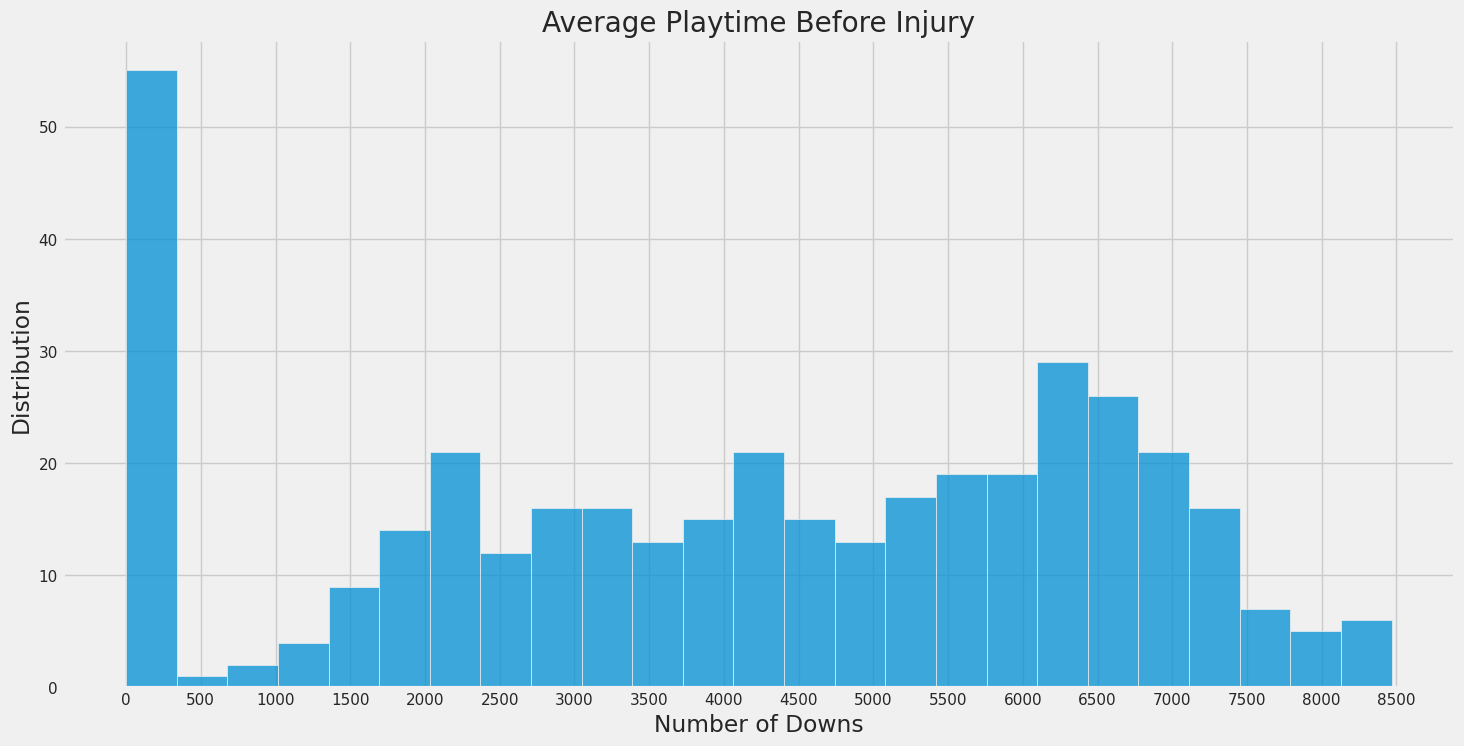

In [ ]:
sns.histplot(x='Average Playtime Before Injury', data=data, bins=25)
plt.xticks(np.arange(0, 9000, 500))

plt.xlabel("Number of Downs")
plt.ylabel("Distribution")
plt.title("Average Playtime Before Injury")


plt.show()

There is a slight increase in number of injuries after playing 6000 downs.

### Total Snaps Distribution

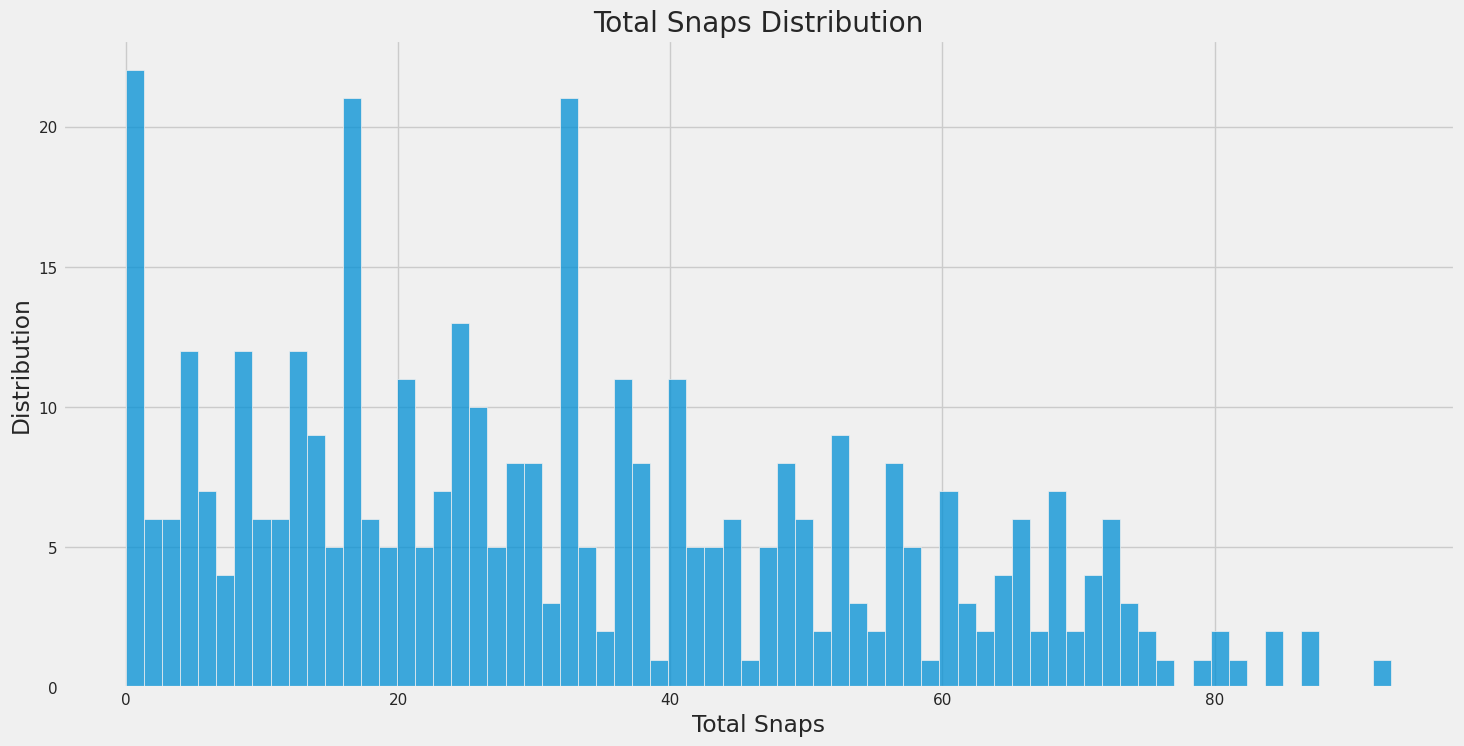

In [ ]:
sns.histplot(x="Total Snaps", bins=70, data=data)

plt.xlabel("Total Snaps")
plt.ylabel("Distribution")
plt.title("Total Snaps Distribution")


plt.show()

Total snaps distribution varies greatly between 0 and 40 snap (in each head injury).

## Machine Learning

After analyzing data manually, and extracting patterns, we build a model to extract features importance, to see what affects the severity of the injury, measured in number of games missed.

First, we encode categorical data.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              392 non-null    object        
 1   Player                          392 non-null    object        
 2   Team                            392 non-null    object        
 3   Game                            392 non-null    object        
 4   Date                            392 non-null    datetime64[ns]
 5   Opposing Team                   392 non-null    object        
 6   Position                        392 non-null    object        
 7   Pre-Season Injury?              392 non-null    object        
 8   Winning Team?                   392 non-null    object        
 9   Week of Injury                  392 non-null    int64         
 10  Season                          392 non-null    object        
 11  Weeks 

In [ ]:
#encoding categorical data
categories = ["Team", "Opposing Team", "Position", "Pre-Season Injury?", "Winning Team?", "Week of Injury", "Season", "Unknown Injury?", "Reported Injury Type"]

In [ ]:
y = data["Games Missed"]
data = data.drop(["Games Missed", "ID", "Player", "Date", "Game"], axis=1)

In [ ]:
data = pd.get_dummies(data, drop_first=True, columns=categories)

In [ ]:
data.head()

,Weeks Injured,Total Snaps,Play Time After Injury,Average Playtime Before Injury,Team_Atlanta Falcons,Team_Baltimore Ravens,Team_Buffalo Bills,Team_Carolina Panthers,Team_Chicago Bears,Team_Cincinnati Bengals,...,Week of Injury_15,Week of Injury_16,Week of Injury_17,Week of Injury_18,Week of Injury_19,Season_2013/2014,Season_2014/2015,Unknown Injury?_Yes,Reported Injury Type_Head,Reported Injury Type_Illness
0,1,0,14,3700,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,78,7350,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,25,1750,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,82,4150,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
x = data

In [ ]:
y.fillna(0, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

Testing different models, and assessing their performance with k-fold cross validation. K-fold validation is useful for smaller datasets, and this dataset is divided into 5 folds, tested and the average performance metrics are listed.

In [ ]:
KFold_Score = pd.DataFrame()
classifiers = ['LinearRegression', 'RandomForestRegressor','GradientBoostingRegressor', 'AdaBoostRegressor']
models = [
          LinearRegression(),
          RandomForestRegressor(n_estimators=200, random_state=0),
          GradientBoostingRegressor(random_state=0),
          AdaBoostRegressor(random_state=0)
         ]

In [ ]:
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score[classifiers[j]] = -(cross_val_score(model, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=cv))
    j = j+1

In [ ]:
mean = pd.DataFrame(KFold_Score.mean(), index= classifiers)
KFold_Score = pd.concat([KFold_Score,mean.T])
KFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4', 'Fold 5', 'Mean']
KFold_Score.T.sort_values(by=['Mean'], ascending = True)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean
RandomForestRegressor,0.904364,0.877273,1.052545,0.845364,0.665278,0.868965
GradientBoostingRegressor,0.937740,0.903628,1.097709,0.990736,0.641872,0.914337
AdaBoostRegressor,1.035549,1.068745,1.172811,1.156247,0.980540,1.082778
LinearRegression,1.382269,1.309331,1.318643,1.252859,1.300145,1.312649


Random Forest Regressor, has the lowest mean absolute error. We use this model to predict number of games missed, using the features offered by the data.

In [ ]:
model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

### Findings

We are using importance scores from the model to deduct which features the model considers most important for making decisions.

In [ ]:
feature_importance = pd.DataFrame(data=model.feature_importances_, index=X_train.columns)
feature_importance.rename(columns={0: "Factors"}, inplace=True)
feature_importance.head()

,Factors
Weeks Injured,0.017627
Total Snaps,0.090576
Play Time After Injury,0.140193
Average Playtime Before Injury,0.073008
Team_Atlanta Falcons,0.001194


In [ ]:
feature_importance = feature_importance["Factors"].nlargest(10)

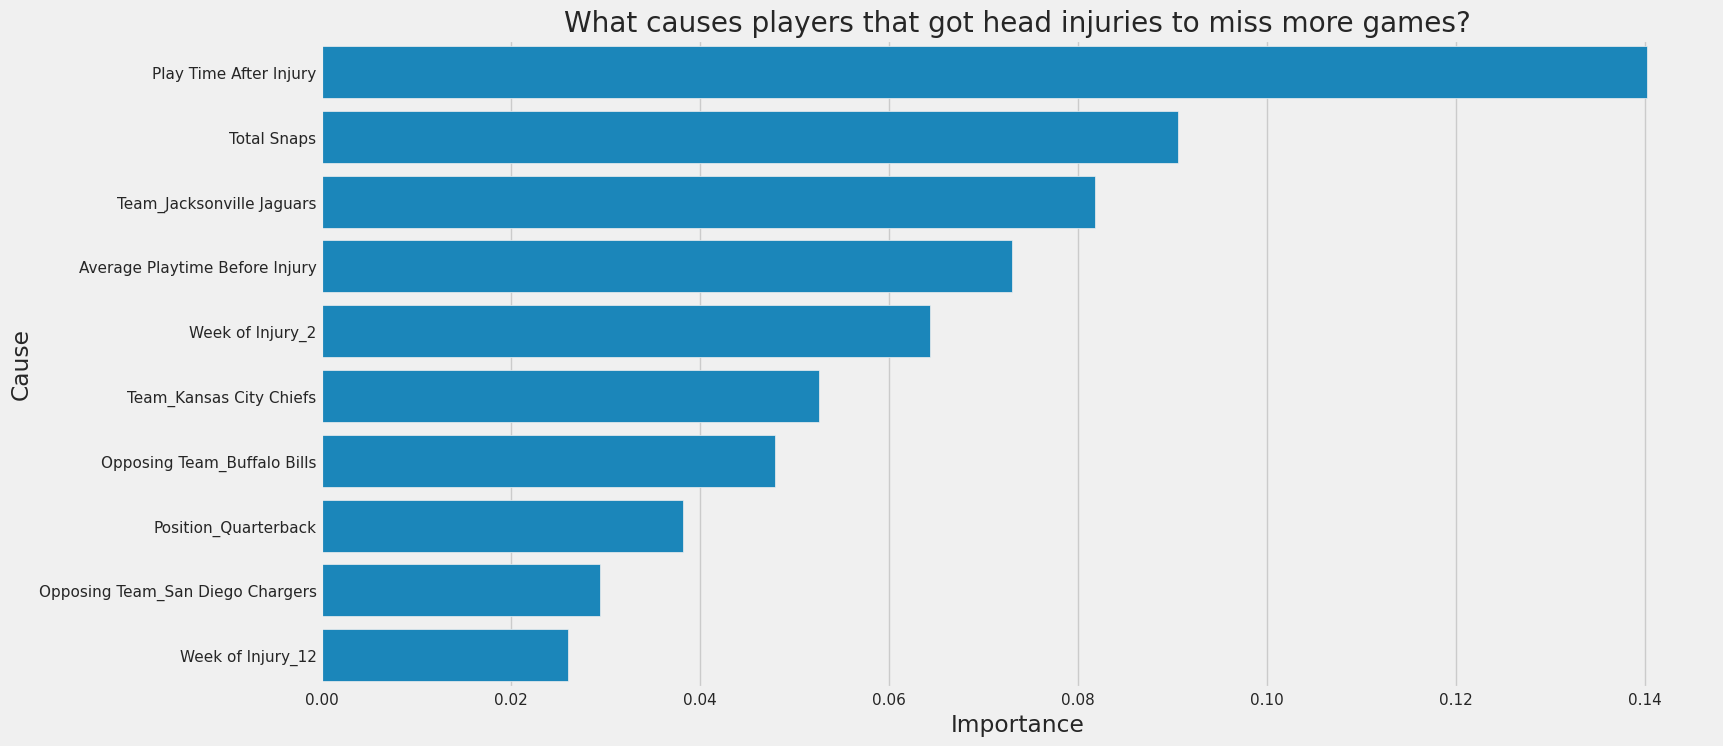

In [ ]:
sns.barplot(y=feature_importance.index, x=feature_importance.values)

plt.xlabel("Importance")
plt.ylabel("Cause")
plt.title("What causes players that got head injuries to miss more games?")

plt.show()

From the plot above we can make conclusions about players, injuries and the games. For example if a fan had their preferred team as the Jacksonville Jaguars, and asked about what the expected performance might be in an upcoming game, our model might inform them that they tend to miss games due to head injuries. Models like this will be of extreme importance in building TouchdownAI.